In [ ]:
# import basic required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
# File uploadation
from google.colab import files
uploaded = files.upload()

Saving smart_energy_meter_Dataset.xlsx to smart_energy_meter_Dataset.xlsx


In [ ]:
# Rename my file then create a dataframe
Energy_Meter = list(uploaded.keys())[0]
df = pd.read_excel(Energy_Meter)

#Process Data


In [ ]:
# Change string time to real time format for dataframe
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Date'] = df['Timestamp'].dt.date

# Sort just to be safe
df = df.sort_values('Timestamp')

# Compute incremental energy between readings
df['Energy_Diff'] = df['Energy (kWh)'].diff().fillna(0)

# Remove negative spikes (due to sensor resets)
df.loc[df['Energy_Diff'] < 0, 'Energy_Diff'] = 0

# Aggregate total energy consumed per day (sum of increments)
daily_energy = df.groupby('Date')['Energy_Diff'].sum().reset_index()
daily_energy.rename(columns={'Energy_Diff': 'Total_Energy_kWh'}, inplace=True)

print(" True Daily Energy Summary:")
print(daily_energy)

 True Daily Energy Summary:
         Date  Total_Energy_kWh
0  2024-10-12           6.56724
1  2024-10-13           6.63324
2  2024-10-14           6.70761
3  2024-10-15           6.61217
4  2024-10-16           6.69369
5  2024-10-17           6.65622
6  2024-10-18           6.63726


#Feature Extract

In [ ]:
daily_energy['Day'] = range(1, len(daily_energy) + 1)
daily_energy['Weekday'] = pd.to_datetime(daily_energy['Date']).dt.weekday
daily_energy['Is_Weekend'] = daily_energy['Weekday'].isin([5,6]).astype(int)

print(" Daily Energy Summary:")
print(daily_energy)

 Daily Energy Summary:
         Date  Total_Energy_kWh  Day  Weekday  Is_Weekend
0  2024-10-12           6.56724    1        5           1
1  2024-10-13           6.63324    2        6           1
2  2024-10-14           6.70761    3        0           0
3  2024-10-15           6.61217    4        1           0
4  2024-10-16           6.69369    5        2           0
5  2024-10-17           6.65622    6        3           0
6  2024-10-18           6.63726    7        4           0


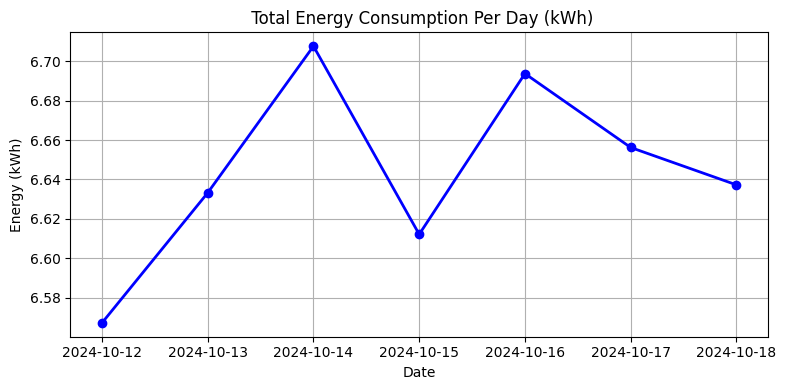

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(daily_energy['Date'], daily_energy['Total_Energy_kWh'], marker='o', linewidth=2, color='blue')
plt.title(" Total Energy Consumption Per Day (kWh)")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Train Model (Linear Regression)

In [ ]:
# Features → Day number, Weekday, Is_Weekend
X = daily_energy[['Day', 'Weekday', 'Is_Weekend']]
y = daily_energy['Total_Energy_kWh']

# Train-test split (keep last 20% of days for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Evaluate Model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n Model Performance:")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R² Score: {r2:.3f}")


 Model Performance:
Mean Absolute Error: 0.043
R² Score: -22.019


In [ ]:
# Predict Next day Energy Usage
next_day_num = len(daily_energy) + 1
next_day_weekday = (daily_energy['Weekday'].iloc[-1] + 1) % 7
is_weekend = 1 if next_day_weekday in [5,6] else 0

next_day_df = pd.DataFrame({
    'Day': [next_day_num],
    'Weekday': [next_day_weekday],
    'Is_Weekend': [is_weekend]
})

predicted_energy = model.predict(next_day_df)[0]
print(f"\n Predicted Energy for Next Day (kWh): {predicted_energy:.3f}")


 Predicted Energy for Next Day (kWh): 6.699


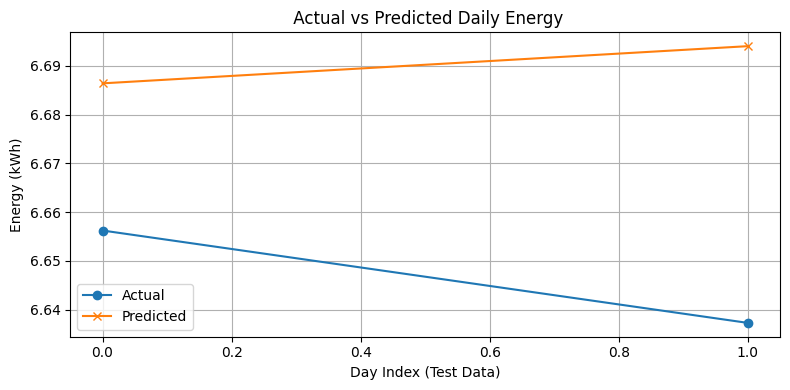

In [ ]:
# Actual vs Predicted Graph
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title(" Actual vs Predicted Daily Energy")
plt.xlabel("Day Index (Test Data)")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()